In [1]:
import sys
cwd = "/Users/jordydikkers/Documents/repos/machi-koro-ai"
sys.path.append(cwd)
import os
os.chdir(cwd)

In [2]:
import pickle
import torch
from buffer import Buffer, BigBuffer
import matplotlib.pyplot as plt
from env_machi_koro_2 import GymMachiKoro2
from mcts_agent import MCTSAgent, PVNet
import torch.nn as nn
import gym
import numpy as np
import itertools
import copy
import mlflow
import random

In [3]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

In [63]:
class MultiDimensionalOneHot:
    def __init__(self, values, device: str = None):
        self.device = device
        # np array where each row is padded with nans
        self.values = torch.tensor(list(itertools.zip_longest(*values, fillvalue=np.nan)), device=self.device, requires_grad=False).T

        # the one_hot_start_indices represent the indices in a flattened array. Each index is the
        # start index of a onehot dimension.
        values_lengths = torch.sum(~torch.isnan( self.values), axis=1)
        self.one_hot_start_indices = values_lengths.cumsum(0) - values_lengths
        
        # the lenght of the flattened onehot array
        self.one_hot_len = sum(map(len, values))
        # self.start_indices = (np.cumsum(n_elements) - n_elements)

    def to_onehot(self, array, batch_size=512):
        # one hot initialized by zeros
        one_hot = torch.zeros((len(array), self.one_hot_len), device=self.device, requires_grad=False)

        # The following line figures out what indices in the flattened onehot array need to be 
        # marked as `1`. It does that by taking the array and figure out the indices at which it
        # equals the self.values array. This results 3 array but only the last one is interesting,
        # therefore [-1] is used. This one is flattened for each row in `array` however, so it is
        # reshaped to (len(array), len(self.values)). Now only the indices for each row in 
        # self.values are known, so the one_hot_start_indices are added to find the indices in the
        # flattened one_hot.
        onehot_indices = torch.where(self.values == array[:,:,None])[-1].reshape(len(array), len(self.values)) + self.one_hot_start_indices
        
        one_hot[torch.arange(len(array))[:, None], onehot_indices] = 1
        return one_hot

class EarlyStopping:
    def __init__(self, patience: int = 10, min_delta: float = 0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.best_epoch = None
        self.best_params = None
        self.wait = 0

    def update(self, loss, epoch, params=None):
        if self.best_loss is None:
            self.best_loss = loss
            self.best_epoch = epoch
            self.best_params = params
        elif self.best_loss - loss > self.min_delta:
            self.best_loss = loss
            self.best_epoch = epoch
            self.best_params = params
            self.wait = 0
        else:
            self.wait += 1
        if self.wait >= self.patience:
            return True
        return False

    def reset(self):
        self.best_loss = None
        self.best_epoch = None
        self.best_params = None
        self.wait = 0

def add_layer(module, name, f_in, f_out, nonlinearity, device, layer_norm=True):
    layer = nn.Linear(f_in, f_out, device=device)
    if nonlinearity in ["softmax", "sigmoid", "tanh"]:
        nn.init.xavier_normal_(layer.weight)
    else:
        nn.init.kaiming_normal_(layer.weight, nonlinearity=nonlinearity)
    module.add_module(name, layer)
    if layer_norm:
        linear_norm = nn.LayerNorm(f_out, device=device)
        module.add_module(f"{name}_norm", linear_norm)
    return module

class PolicyNet(nn.Module):
    def __init__(
            self,
            f_in,
            f_out,
            device: str = None,
    ):
        super().__init__()
        self.device = device
        self.logits = nn.Sequential()
        self.logits = add_layer(self.logits, "logits1", f_in, 128, "relu", self.device)
        self.logits.add_module("logits_relu1", nn.ReLU())
        self.logits = add_layer(self.logits, "logits2", 128, 128, "relu", self.device)
        self.logits.add_module("logits_relu2", nn.ReLU())
        self.logits = add_layer(self.logits, "logits3", 128, 128, "relu", self.device)
        self.logits.add_module("logits_relu3", nn.ReLU())
        self.logits = add_layer(self.logits, "logits4", 128, 128, "relu", self.device)
        self.logits.add_module("logits_relu4", nn.ReLU())
        self.logits = add_layer(self.logits, "logits5", 128, f_out, "softmax", self.device)
        self.KLDiv = torch.nn.KLDivLoss(reduction="batchmean")

    def forward(self, x):
        return self.logits(x)
        
    
    def loss(self, policy_preds, policy_targets):
        policy_loss = self.KLDiv(torch.nn.functional.log_softmax(policy_preds), policy_targets)
        return policy_loss
    
class ValueNet(nn.Module):
    def __init__(
            self,
            f_in,
            f_out,
            device: str = None,
    ):
        super().__init__()
        self.device = device
        self.value = nn.Sequential()
        self.value = add_layer(self.value, "value1", f_in, 10, "relu", self.device)
        self.value.add_module("value_relu1", nn.ReLU())
        self.value = add_layer(self.value, "value2", 10, 128, "relu", self.device)
        self.value.add_module("value_relu2", nn.ReLU())
        self.value = add_layer(self.value, "value3", 128, 128, "relu", self.device)
        self.value.add_module("value_relu3", nn.ReLU())
        self.value = add_layer(self.value, "value4", 128, 10, "relu", self.device)
        self.value.add_module("value_relu4", nn.ReLU())
        self.value = add_layer(self.value, "value5", 10, f_out, "tanh", self.device, layer_norm=False)
        self.value.add_module("value_tanh5", nn.Tanh())

    def forward(self, x):
        return self.value(x)
    
    def loss(self, value_preds, value_targets):
        value_loss = torch.nn.functional.mse_loss(value_preds, value_targets)
        return value_loss

class PVNet:
    def __init__(
            self,
            env_cls,
            env_kwargs,
            uniform_pvnet: bool = False,
            custom_policy_edit: bool = False,
            custom_value: bool = False,
            device: str = None,
    ):
        env = env_cls(**env_kwargs)
        self.env = env
        self.use_uniform_pvnet = uniform_pvnet
        self.use_custom_policy_edit = custom_policy_edit
        self.use_custom_value = custom_value
        self.device = device
        self._landmark_indices_in_action = [env._action_str_to_idx[landmark] for landmark in env._env._landmarks]
        self.landmarks_cost = [env.card_info[landmark]["cost"] for landmark in env._env._landmarks]
        # num_inputs = gym.spaces.flatten_space(observation_space).shape[0]
        
        self.one_dice_rolls = np.array([1,2,3,4,5,6])
        self.one_dice_probs = np.array([1,1,1,1,1,1])/6
        self.two_dice_rolls = np.array([2,3,4,5,6,7,8,9,10,11,12])
        self.two_dice_probs = np.array([1,2,3,4,5,6,5,4,3,2,1])/36
        

        one_hot_indices = []
        one_hot_values = []
        identity_indices = []
        one_hot_index_names = []
        identity_index_names = []
        for player in env.observation_indices["player_info"].keys():
            for card in env.observation_indices["player_info"][player]["cards"].keys():
                card_index = env.observation_indices["player_info"][player]["cards"][card]
                # card_values = env.observation_values["player_info"][player]["cards"][card]
                # one_hot_indices.append(card_index)
                # one_hot_values.append(card_values)
                identity_indices.append(card_index)
                identity_index_names.append(f"player_info/{player}/{card}")

            identity_indices.append(env.observation_indices["player_info"][player]["coins"])
            identity_index_names.append(f"player_info/{player}/coins")

        for alley in env.observation_indices["marketplace"].keys():
            for pos in env.observation_indices["marketplace"][alley].keys():
                card_index = env.observation_indices["marketplace"][alley][pos]["card"]
                card_values = env.observation_values["marketplace"][alley][pos]["card"]
                one_hot_indices.append(card_index)
                one_hot_values.append(card_values)
                one_hot_index_names.extend([f"marketplace/{alley}/{pos}/card/{env._env._card_num_to_name[num]}" for num in card_values])

                if alley != "landmarks":
                    count_index = env.observation_indices["marketplace"][alley][pos]["count"]
                    # count_values = env.observation_values["marketplace"][alley][pos]["count"]
                    # one_hot_indices.append(count_index)
                    # one_hot_values.append(count_values)
                    identity_indices.append(count_index)
                    identity_index_names.append(f"marketplace/{alley}/{pos}/count")

        one_hot_indices.append(env.observation_indices["current_player_index"])
        one_hot_values.append(env.observation_values["current_player_index"])
        one_hot_index_names.extend([f"current_player_index/{i}" for i in env.observation_values["current_player_index"]])

        one_hot_indices.append(env.observation_indices["current_stage_index"])
        one_hot_values.append(env.observation_values["current_stage_index"])
        one_hot_index_names.extend([f"current_stage_index/{i}" for i in env.observation_values["current_stage_index"]])

        one_hot_indices.append(env.observation_indices["another_turn"])
        one_hot_values.append(env.observation_values["another_turn"])
        one_hot_index_names.extend([f"another_turn/{i}" for i in env.observation_values["another_turn"]])

        one_hot_indices.append(env.observation_indices["build_rounds_left"])
        one_hot_values.append(env.observation_values["build_rounds_left"])
        one_hot_index_names.extend([f"build_rounds_left/{i}" for i in env.observation_values["build_rounds_left"]])

        self._one_hot_indices = one_hot_indices
        self._identity_indices = identity_indices
        self._input_names = one_hot_index_names + identity_index_names

        self._one_hot_indices_tensor = torch.tensor(np.array(one_hot_indices), device=self.device, requires_grad=False)
        self._identity_indices_tensor = torch.tensor(np.array(identity_indices), device=self.device, requires_grad=False)
        self._mdoh = MultiDimensionalOneHot(one_hot_values)

        num_inputs = self._mdoh.one_hot_len + len(self._identity_indices)
        num_outputs = self.env.action_space.n

        self.policy_net = PolicyNet(num_inputs, num_outputs, device=self.device)
        self.value_net = ValueNet(num_inputs, 1, device=self.device)
        
        self.is_trained = False
        self.KLDiv = torch.nn.KLDivLoss(reduction="batchmean")

    def add_layer(self, module, name, f_in, f_out, nonlinearity, device, layer_norm=True):
        layer = nn.Linear(f_in, f_out, device=device)
        if nonlinearity in ["softmax", "sigmoid", "tanh"]:
            nn.init.xavier_normal_(layer.weight)
        else:
            nn.init.kaiming_normal_(layer.weight, nonlinearity=nonlinearity)
        module.add_module(name, layer)
        if layer_norm:
            linear_norm = nn.LayerNorm(f_out, device=device)
            module.add_module(f"{name}_norm", linear_norm)
        return module

    def obss_to_onehot(self, obss):
        return torch.cat((self._mdoh.to_onehot(obss[:, self._one_hot_indices]), obss[:, self._identity_indices]), axis=1)

    def pred_policy(self, observation):
        logits = self.logits(observation)
        return logits
    
    def pred_value(self, observation):
        value = self.value(observation)
        return value

    def predict(self, observation):
        with torch.no_grad():
            if self.use_uniform_pvnet:
                policy_pred, value_pred = torch.ones((1, self.env.action_space.n)), torch.zeros((1, 1))
                policy_pred = policy_pred + 0.01*torch.randn((1, self.env.action_space.n))
            else:
                input = torch.tensor(observation).unsqueeze(0).to(torch.float32)
                policy_pred, value_pred = self.policy_net(input), self.value_net(input)
            # overwrite policy or value if specified.
            if self.use_custom_policy_edit:
                policy_pred = self.custom_policy_edit(observation, policy_pred)
            if self.use_custom_value:
                value_pred = self.custom_value(observation)

            policy_pred = torch.nn.functional.softmax(policy_pred, 1)
            if policy_pred.device.type != "cpu":
                policy_pred = policy_pred.cpu()
            if value_pred.device.type != "cpu":
                value_pred = value_pred.cpu()
            return policy_pred.squeeze().detach().numpy(), value_pred.squeeze(0).detach().numpy()

    def scale_x(self, x):
        x[:, self._identity_indices_tensor] = (x[:, self._identity_indices_tensor] - self.x_mean) / self.x_std
        return x

    def train(
            self,
            batch_size,
            epochs,
            train_val_split,
            lr,
            weight_decay,
            buffer: Buffer | None = None,
            train_buffer: Buffer | None = None,
            val_buffer: Buffer | None = None,
        ):
        if buffer is not None:
            buffer.compute_values()
            train_buffer, val_buffer = buffer.split_buffer_by_episode(train_val_split)
        else:
            assert train_buffer is not None and val_buffer is not None
        self.x_mean = torch.tensor(train_buffer.obss[:, self._identity_indices].mean(axis=0).astype(np.float32), device=self.device, requires_grad=False)
        self.x_std = torch.tensor(train_buffer.obss[:, self._identity_indices].std(axis=0).astype(np.float32), device=self.device, requires_grad=False)


        avg_train_loss = None
        avg_val_loss = None
        epoch = 0

        obss_train, _, _, _, _, _, _, values_train, _, _, probs_train = train_buffer[:]
        obss_train = torch.tensor(obss_train.astype(np.float32))
        obss_train = self.obss_to_onehot(obss_train)
        values_train = torch.tensor(values_train.astype(np.float32))
        probs_train = torch.tensor(probs_train.astype(np.float32))
        obss_train, values_train, probs_train = obss_train.to(self.device), values_train.to(self.device), probs_train.to(self.device)

        obss_val, _, _, _, _, _, _, values_val, _, _, probs_val = val_buffer[:]
        obss_val = torch.tensor(obss_val.astype(np.float32))
        obss_val = self.obss_to_onehot(obss_val)
        values_val = torch.tensor(values_val.astype(np.float32))
        probs_val = torch.tensor(probs_val.astype(np.float32))
        obss_val, values_val, probs_val = obss_val.to(self.device), values_val.to(self.device), probs_val.to(self.device)


        policy_optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=lr, weight_decay=weight_decay)
        value_optimizer = torch.optim.Adam(self.value_net.parameters(), lr=lr, weight_decay=weight_decay)

        policy_early_stopping = EarlyStopping(patience=5)
        value_early_stopping = EarlyStopping(patience=5)

        policy_done = False
        value_done = False

        for epoch in range(epochs):

            with torch.no_grad():
                if not policy_done:
                    prob_preds = self.policy_net(torch.tensor(obss_val))
                    avg_val_policy_loss = self.policy_net.loss(prob_preds, torch.tensor(probs_val))

                    if policy_early_stopping.update(avg_val_policy_loss, epoch, self.policy_net.state_dict()):
                        print("policy net is done!")
                        policy_done = True

                if not value_done:
                    value_preds = self.value_net(torch.tensor(obss_val))
                    avg_val_value_loss = self.value_net.loss(value_preds, torch.tensor(values_val))

                    if value_early_stopping.update(avg_val_value_loss, epoch, self.value_net.state_dict()):
                        print("value net is done!")
                        value_done = True
            
            if policy_done and value_done:
                break

            indices_for_all_batches = train_buffer.get_random_batch_indices(batch_size)

            tot_train_policy_loss = 0
            tot_train_value_loss = 0
            train_steps_since_last_val_step = 0
            n_batches = len(indices_for_all_batches)
            print(n_batches)
            for i, batch_indices in enumerate(indices_for_all_batches):
                train_steps_since_last_val_step += 1

                if not policy_done:
                    prob_preds = self.policy_net(torch.tensor(obss_train[batch_indices]))
                    policy_loss = self.policy_net.loss(prob_preds, torch.tensor(probs_train[batch_indices]))

                    policy_optimizer.zero_grad()
                    policy_loss.backward()
                    policy_optimizer.step()

                    tot_train_policy_loss += policy_loss.detach()
                    avg_train_policy_loss = tot_train_policy_loss/train_steps_since_last_val_step

                if not value_done:
                    value_preds = self.value_net(torch.tensor(obss_train[batch_indices]))
                    value_loss = self.value_net.loss(value_preds, torch.tensor(values_train[batch_indices]))

                    value_optimizer.zero_grad()
                    value_loss.backward()
                    value_optimizer.step()

                    tot_train_value_loss += value_loss.detach()
                    avg_train_value_loss = tot_train_value_loss/train_steps_since_last_val_step

                avg_train_loss = avg_train_policy_loss + avg_train_value_loss

                if i % 100 == 0:
                    with torch.no_grad():
                        if not policy_done:
                            prob_preds = self.policy_net(torch.tensor(obss_val))
                            avg_val_policy_loss = self.policy_net.loss(prob_preds, torch.tensor(probs_val))

                        if not value_done:
                            value_preds = self.value_net(torch.tensor(obss_val))
                            avg_val_value_loss = self.value_net.loss(value_preds, torch.tensor(values_val))

                        avg_val_loss = avg_val_policy_loss + avg_val_value_loss

                        print(f"epoch: {epoch} {round(i/n_batches * 100)}% | train_loss | {avg_train_loss} | val_loss: {avg_val_loss} | train_policy_loss: {avg_train_policy_loss} | train_value_loss: {avg_train_value_loss} | val_policy_loss: {avg_val_policy_loss} | val_value_loss: {avg_val_value_loss} | policy_done: {policy_done} | value_done: {value_done}", end="\r")
                        mlflow.log_metric("epoch", epoch, step=i)
                        mlflow.log_metric("train_policy_loss", avg_train_policy_loss, step=i)
                        mlflow.log_metric("train_value_loss", avg_train_value_loss, step=i)
                        mlflow.log_metric("val_policy_loss", avg_val_policy_loss, step=i)
                        mlflow.log_metric("val_value_loss", avg_val_value_loss, step=i)
                        mlflow.log_metric("train_loss", avg_train_loss, step=i)
                        mlflow.log_metric("val_loss", avg_val_loss, step=i)
                        tot_train_policy_loss = 0
                        tot_train_value_loss = 0
                        train_steps_since_last_val_step = 0
            
            if policy_done and value_done:
                break

        self.policy_net.load_state_dict(policy_early_stopping.best_params)
        self.value_net.load_state_dict(value_early_stopping.best_params)

        print(f"epoch: {epoch} | train_loss | {avg_train_loss} | val_loss: {avg_val_loss} | train_policy_loss: {avg_train_policy_loss} | train_value_loss: {avg_train_value_loss} | val_policy_loss: {avg_val_policy_loss} | val_value_loss: {avg_val_value_loss} | policy_done: {policy_done} | value_done: {value_done}")
        return train_buffer, val_buffer, avg_train_loss, avg_val_loss
    
    def save(self, folder):
        torch.save(self.policy_net.state_dict(), folder+"/policy_net.ckpt")
        torch.save(self.value_net.state_dict(), folder+"/value_net.ckpt")

    def load(self, folder):
        self.policy_net.load_state_dict(torch.load(folder+"/policy_net.ckpt"))
        self.value_net.load_state_dict(torch.load(folder+"/value_net.ckpt"))


In [64]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
PVNET_TRAIN_EPOCHS = 10
BATCH_SIZE = 2048
CARD_INFO_PATH = "card_info_machi_koro_2.yaml"
N_PLAYERS = 2
TRAIN_VAL_SPLIT = 0.2
LR = 0.001
WEIGHT_DECAY = 1e-5

train_buffer_path = "checkpoints/2024-04-22 19:41:13.984945/train_buffer.pkl"
val_buffer_path = "checkpoints/2024-04-22 19:41:13.984945/val_buffer.pkl"

with open(train_buffer_path, "rb") as f:
    train_buffer = pickle.load(f)

with open(val_buffer_path, "rb") as f:
    val_buffer = pickle.load(f)

env_cls = GymMachiKoro2
env_kwargs = {"n_players": N_PLAYERS, "card_info_path": CARD_INFO_PATH}
temp_env = env_cls(**env_kwargs)

pvnet_cls = PVNet
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
else:
    print ("MPS device not found.")
pvnet_kwargs = {
    "env_cls": env_cls,
    "env_kwargs": env_kwargs,
    "device": "cpu"#mps_device
}
pvnet_for_training = PVNet(**pvnet_kwargs)

# pvnet_for_training.to(mps_device)
# # pvnet_for_training.load_state_dict(torch.load("pvnet.ckpt"))
# mlflow.set_experiment("Notebook Experiment Machi Koro 2")
# with mlflow.start_run() as run:
#     train_buffer, val_buffer, avg_train_loss, avg_val_loss = pvnet_for_training.train(
#         batch_size=BATCH_SIZE,
#         epochs=PVNET_TRAIN_EPOCHS,
#         train_val_split=TRAIN_VAL_SPLIT,
#         lr=LR,
#         weight_decay=WEIGHT_DECAY,
#         # buffer=buffer,
#         train_buffer=train_buffer,
#         val_buffer=val_buffer
#     )

In [ ]:
def flatten_state_indices(d, key_chain=[]):
    flattened_d = {}
    for k, v in d.items():
        if isinstance(v, dict):
            flattened_d = flattened_d | flatten_state_indices(v, key_chain + [k])
        else:
            flattened_d[v] = "/".join(key_chain + [k])
    return flattened_d

In [ ]:
import matplotlib.pyplot as plt
import plotly.express as px
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

pvnet_for_training.value.value1.register_forward_hook(get_activation('value1'))
pvnet_for_training.value.value1.register_forward_hook(get_activation('value2'))
pvnet_for_training.value.value1.register_forward_hook(get_activation('value3'))

x = torch.tensor(train_buffer.obss[[0]].astype(np.float32))
x = pvnet_for_training.obss_to_onehot(x).to(mps_device)
output = pvnet_for_training(x)
# plt.matshow(activations['value1'].cpu().numpy())
fig = px.imshow(
    pvnet_for_training.value.value1.weight.data.cpu().numpy() > 0,
    # activations['value1'].cpu().numpy()
    x=pvnet_for_training._input_names
)
# fig = px.imshow(
#     pvnet_for_training.value.value3.weight.data.cpu().numpy()
# )

# removing x labels
fig.update_xaxes(showticklabels=False)

# writing fig to html
fig.write_html("value1.html")

fig.show()
# # the above is without colorbar, the below is with colorbar. making sure is is plotted as a large image
# fig, ax = plt.subplots()
# cax = ax.matshow(pvnet_for_training.value.value1.weight.data.cpu().numpy())
# fig.colorbar(cax)
# plt.show()

In [ ]:
train_buffer_path = "train_buffer.pkl"
val_buffer_path = "val_buffer.pkl"
with open(train_buffer_path, "wb") as file:
    pickle.dump(train_buffer, file)
with open(val_buffer_path, "wb") as file:
    pickle.dump(val_buffer, file)


In [59]:
#mps

import time
obss, actions, rewards, next_obss, dones, player_ids, action_masks, values, value_preds, values_mcts, probs = val_buffer.get_episode(6)
time_start = time.time()
for i in range(5):
    prob_preds, value_preds = pvnet_for_training.predict(pvnet_for_training.obss_to_onehot(torch.tensor(obss.astype(np.float32))).to(mps_device))
    print(prob_preds, value_preds)
time_end = time.time()

print(time_end - time_start)

/var/folders/1s/8ms0ttc14n93dk7b_dg7sf6w0000gn/T/ipykernel_92622/859830424.py:256: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(observation).unsqueeze(0).to(torch.float32)


RuntimeError: Placeholder storage has not been allocated on MPS device!

In [60]:
#cpu

import time
obss, actions, rewards, next_obss, dones, player_ids, action_masks, values, value_preds, values_mcts, probs = val_buffer.get_episode(6)
time_start = time.time()
for i in range(5):
    prob_preds, value_preds = pvnet_for_training.predict(pvnet_for_training.obss_to_onehot(torch.tensor(obss.astype(np.float32))))
    print(prob_preds, value_preds)
time_end = time.time()

print(time_end - time_start)

[[0.02232713 0.01813605 0.01072338 ... 0.00999575 0.01470399 0.00567012]
 [0.0166896  0.01719663 0.01182075 ... 0.01114487 0.01517618 0.00684222]
 [0.00970403 0.00638766 0.01334552 ... 0.0062555  0.01335172 0.00849683]
 ...
 [0.0167391  0.01304577 0.01027227 ... 0.02232326 0.0117558  0.00646705]
 [0.01795562 0.01311099 0.01134351 ... 0.02313603 0.01054099 0.00609053]
 [0.01385325 0.01083416 0.00726878 ... 0.01541394 0.00915147 0.00770378]] [[ 0.12223575]
 [-0.0532615 ]
 [-0.03271148]
 [-0.2447763 ]
 [ 0.00857869]
 [-0.12868625]
 [ 0.07041945]
 [-0.05955557]
 [ 0.12995319]
 [ 0.06040642]
 [ 0.28890306]
 [ 0.33963013]
 [ 0.44485664]
 [ 0.3995431 ]
 [ 0.60704625]
 [ 0.59253705]
 [ 0.524143  ]
 [ 0.18743958]
 [ 0.5803713 ]
 [ 0.5602747 ]
 [ 0.50547075]
 [-0.2577597 ]
 [ 0.24067646]
 [ 0.30618894]
 [ 0.21807669]
 [ 0.21325085]
 [ 0.23488325]
 [ 0.25596264]
 [ 0.34685984]
 [ 0.36239487]
 [ 0.3453217 ]
 [ 0.37597492]
 [ 0.35957778]
 [ 0.5526953 ]
 [ 0.43534303]
 [-0.1657067 ]
 [-0.2859051 ]
 

/var/folders/1s/8ms0ttc14n93dk7b_dg7sf6w0000gn/T/ipykernel_92622/859830424.py:256: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(observation).unsqueeze(0).to(torch.float32)


winning player: [0.]


/var/folders/1s/8ms0ttc14n93dk7b_dg7sf6w0000gn/T/ipykernel_92622/2627999906.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(observation).unsqueeze(0).to(torch.float32)


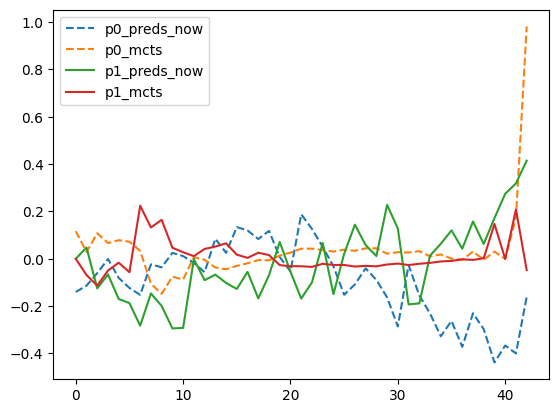

In [26]:
obss, actions, rewards, next_obss, dones, player_ids, action_masks, values, value_preds, values_mcts, probs = val_buffer.get_episode(6)


prob_preds, value_preds = pvnet_for_training.predict(pvnet_for_training.obss_to_onehot(torch.tensor(obss.astype(np.float32))).to(mps_device))
# p0_indices, _ = np.where(player_ids == 0)
# p1_indices, _  = np.where(player_ids == 1)
# print(f"winning player: {player_ids[-1]}")
# plt.plot(np.arange(len(p0_indices)), value_preds[p0_indices], "--", label="p0_preds_now")
# plt.plot(np.arange(len(p0_indices)), values_mcts[p0_indices], "--", label="p0_mcts")
# plt.plot(np.arange(len(p1_indices)), value_preds[p1_indices], "-", label="p1_preds_now")
# plt.plot(np.arange(len(p1_indices)), values_mcts[p1_indices], "-", label="p1_mcts")
# plt.legend(loc="upper left")
# plt.show()

In [ ]:
val_buffer._episode_starts, val_buffer._episode_ends, train_buffer._episode_starts, train_buffer._episode_ends

In [ ]:
p0_indices, p1_indices

In [ ]:
torch.save(pvnet_for_training.state_dict(), "pvnet.ckpt")